# Analysis of `wandb` Logs and Metrics
This notebook collects different metrics for a specified experiment.

# Setup

In [1]:
import numpy as np
import pprint
from typing import Literal, List
from json import loads, dumps

import warnings

warnings.filterwarnings("ignore")

import wandb

api = wandb.Api()

import pandas as pd

In [2]:
runs = api.runs("uedyiuajxz-personal/qfl-prod-le-3")

In [3]:
groups = list(set(run.config.get("group", None) for run in runs))
print(groups)

['Standard-fedqnn-15229098', 'Standard-qcnn-15212915', 'Standard-fednn-15245040', 'FHE-qcnn-15229101', 'FHE-fedqnn-15247801', 'FHE-resnet18-qcnn-15266107', 'Standard-resnet18-qnn-15229104', 'Standard-resnet18-qcnn-15229106', 'FHE-resnet18-qnn-15212920', 'Standard-qcnn-15229100', 'FHE-fedqnn-15233986', 'Standard-fednn-15247798', 'Standard-fedqnn-15212913', 'Standard-fednn-15233983', 'Standard-resnet18-15247804', 'FHE-fednn-15245041', 'FHE-qcnn-15246673', 'FHE-qcnn-15233988', 'FHE-resnet18-qnn-15247807', 'FHE-resnet18-qnn-15233992', 'Standard-resnet18-qcnn-15212921', 'Standard-qcnn-15245044', 'FHE-qcnn-15247803', 'FHE-resnet18-qcnn-15258769', 'FHE-resnet18-qcnn-15252851', 'Standard-resnet18-qcnn-15247808', 'FHE-resnet18-qcnn-15278314', 'FHE-fednn-15247799', 'FHE-resnet18-qnn-15229105', 'Standard-resnet18-qnn-15212919', 'Standard-resnet18-qnn-15245048', 'FHE-fedqnn-15245043', 'Standard-resnet18-qcnn-15245050', 'FHE-resnet18-15233990', 'Standard-resnet18-qcnn-15233993', 'Standard-fednn-152

# EDA

In [4]:
group_in_focus = groups[0]

In [5]:
grouped_runs = [run for run in runs if run.config.get("group", None) == group_in_focus]
server = None
clients = []

for run in grouped_runs:
    participant = run.config.get("participant", None)
    if participant == "server":
        server = run
    else:
        clients.append(run)
    print(f"Run ID: {run.id}, Name: {run.name}, Type: {participant}")

Run ID: 007au094, Name: server, Type: server
Run ID: 026uua3u, Name: client8, Type: client8
Run ID: 101cyz3m, Name: client2, Type: client2
Run ID: 67mqhl71, Name: client0, Type: client0
Run ID: 6envolfe, Name: client11, Type: client11
Run ID: 9ty7g27x, Name: client7, Type: client7
Run ID: b0u2535p, Name: client14, Type: client14
Run ID: haxbxj28, Name: client18, Type: client18
Run ID: ib1g8wzf, Name: client17, Type: client17
Run ID: k698f3sb, Name: client4, Type: client4
Run ID: nanafiol, Name: client5, Type: client5
Run ID: p3htvod7, Name: client16, Type: client16
Run ID: sqgypj7o, Name: client15, Type: client15
Run ID: ty2q85f4, Name: client1, Type: client1
Run ID: xbknhi10, Name: client12, Type: client12
Run ID: yiahqkih, Name: client3, Type: client3
Run ID: ytn1bw8p, Name: client10, Type: client10
Run ID: zv6528lh, Name: client6, Type: client6
Run ID: 9qxe7ekp, Name: client9, Type: client9
Run ID: w9xu7ny1, Name: client19, Type: client19
Run ID: bmm49a13, Name: client13, Type: clie

## Settings

In [6]:
pp = pprint.PrettyPrinter(indent=1, width=40)
pp.pprint(server.config)

{'batch_size': 32,
 'dataset': 'MRI',
 'fhe_enabled': False,
 'group': 'Standard-fedqnn-15229098',
 'learning_rate': '1e-3',
 'model': 'fedqnn',
 'number_clients': 20,
 'participant': 'server',
 'rounds': 20}


## Server and Aggregated Metrics

In [7]:
def compute_statistics(arr: np.ndarray) -> dict:
    """
    Compute basic statistical measures of an array, including mean, median, standard deviation,
    25th percentile (Q1), and 75th percentile (Q3).

    Parameters
    ----------
    arr : np.ndarray
        Input numerical array.

    Returns
    -------
    dict
        A dictionary containing the following statistics:
        - "mean" : float
            The average of the array.
        - "median" : float
            The middle value of the array.
        - "std" : float
            The standard deviation (sample standard deviation with `ddof=1`).
        - "25%" : float
            The 25th percentile (Q1).
        - "75%" : float
            The 75th percentile (Q3).

    Examples
    --------
    >>> import numpy as np
    >>> data = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    >>> compute_statistics(data)
    {'mean': 55.0, 'median': 55.0, 'std': 30.276503540974915, '25%': 32.5, '75%': 77.5}
    """
    if not isinstance(arr, np.ndarray):
        arr = np.array(arr)

    stats = {
        "mean": np.mean(arr),
        "median": np.median(arr),
        "std": np.std(arr, ddof=1),
        "25%": np.percentile(arr, 25),
        "75%": np.percentile(arr, 75),
        "min": np.min(arr),
        "max": np.max(arr),
        "last_value": arr[-1],
    }
    return stats

In [8]:
from rich.console import Console
from rich.table import Table

console = Console()

# Create Table 1 (Basic Stats: Mean, Median, Std)
table1 = Table(title="Server Statistics (Part 1)")
table1.add_column("Metric", justify="left", style="cyan", min_width=20)
table1.add_column("Mean", justify="right", style="green", min_width=12)
table1.add_column("Median", justify="right", style="green", min_width=12)
table1.add_column("Std", justify="right", style="green", min_width=12)

# Create Table 2 (Percentiles + Min/Max/Last Value)
table2 = Table(title="Server Statistics (Part 2)")
table2.add_column("Metric", justify="left", style="cyan", min_width=20)
table2.add_column("25%", justify="right", style="green", min_width=12)
table2.add_column("75%", justify="right", style="green", min_width=12)
table2.add_column("Max", justify="right", style="green", min_width=12)
table2.add_column("Min", justify="right", style="green", min_width=12)
table2.add_column("Last", justify="right", style="green", min_width=12)

server_history = server.history()
for metric in server_history.keys():
    metric_values = [val for val in server_history[metric] if not np.isnan(val)]
    stats = compute_statistics(metric_values)

    # Add row to Table 1
    table1.add_row(
        metric, f"{stats['mean']:.2f}", f"{stats['median']:.2f}", f"{stats['std']:.2f}"
    )

    # Add row to Table 2
    table2.add_row(
        metric,
        f"{stats['25%']:.2f}",
        f"{stats['75%']:.2f}",
        f"{stats['max']:.2f}",
        f"{stats['min']:.2f}",
        f"{stats['last_value']:.2f}",
    )


console.print(table1)
console.print(table2)

                         Server Statistics (Part 1)                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Metric                     ┃          Mean ┃        Median ┃          Std ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ loss_central               │          1.07 │          1.06 │         0.12 │
│ total_training_time        │      17566.83 │      17566.83 │          nan │
│ metrics_agg.accuracy       │         61.65 │         63.64 │         6.12 │
│ Bytes Sent (Round)         │      10004.00 │      10004.00 │         0.00 │
│ metrics_agg.recalls        │          0.60 │          0.62 │         0.06 │
│ trainable_parameters       │       2112.00 │       2112.00 │          nan │
│ Bytes Received (Round)     │     200080.00 │     200080.00 │         0.00 │
│ _runtime                   │       9220.63 │       9265.39 │      5617.56 │
│ _step                      │         10.50 │         10.50 │         6.49 │
│ metrics_agg.precisions     │          0.57 │          0.61 │         0.10 │
│ metrics_central.accuracy   │         55.08 │         58.38 │         8.80 │
│ round_time                 │        856.72 │        857.31 │         2.70 │
│ Total Bytes Received       │    2100840.00 │    2100840.00 │   1183689.24 │
│ metrics_agg.f1s            │          0.56 │          0.59 │         0.09 │
│ Total Bytes Sent           │     105042.00 │     105042.00 │     59184.46 │
│ loss_agg                   │          0.90 │          0.88 │         0.11 │
│ round                      │         10.50 │         10.50 │         5.92 │
│ parameter_aggregation_time │          0.03 │          0.03 │         0.00 │
│ _timestamp                 │ 1754004517.71 │ 1754004562.48 │      5617.55 │
└────────────────────────────┴───────────────┴───────────────┴──────────────┘

                                          Server Statistics (Part 2)                                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Metric                     ┃           25% ┃           75% ┃           Max ┃           Min ┃          Last ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ loss_central               │          0.99 │          1.12 │          1.43 │          0.92 │          0.92 │
│ total_training_time        │      17566.83 │      17566.83 │      17566.83 │      17566.83 │      17566.83 │
│ metrics_agg.accuracy       │         60.62 │         65.07 │         65.78 │         38.34 │         65.78 │
│ Bytes Sent (Round)         │      10004.00 │      10004.00 │      10004.00 │      10004.00 │      10004.00 │
│ metrics_agg.recalls        │          0.58 │          0.63 │          0.64 │          0.36 │          0.64 │
│ trainable_parameters       │       2112.00 │       2112.00 │       2112.00 │       2112.00 │       2112.00 │
│ Bytes Received (Round)     │     200080.00 │     200080.00 │     200080.00 │     200080.00 │     200080.00 │
│ _runtime                   │       4674.17 │      13850.82 │      17567.98 │         10.84 │      17567.98 │
│ _step                      │          5.25 │         15.75 │         21.00 │          0.00 │         21.00 │
│ metrics_agg.precisions     │          0.58 │          0.63 │          0.64 │          0.21 │          0.64 │
│ metrics_central.accuracy   │         54.26 │         59.60 │         61.13 │         23.78 │         61.05 │
│ round_time                 │        856.08 │        857.94 │        859.55 │        846.66 │        855.22 │
│ Total Bytes Received       │    1150460.00 │    3051220.00 │    4001600.00 │     200080.00 │    4001600.00 │
│ metrics_agg.f1s            │          0.55 │          0.62 │          0.63 │          0.26 │          0.63 │
│ Total Bytes Sent           │      57523.00 │     152561.00 │     200080.00 │      10004.00 │     200080.00 │
│ loss_agg                   │          0.83 │          0.94 │          1.28 │          0.78 │          0.78 │
│ round                      │          5.75 │         15.25 │         20.00 │          1.00 │         20.00 │
│ parameter_aggregation_time │          0.03 │          0.03 │          0.04 │          0.03 │          0.04 │
│ _timestamp                 │ 1753999971.24 │ 1754009147.92 │ 1754012864.91 │ 1753995307.95 │ 1754012864.91 │
└────────────────────────────┴───────────────┴───────────────┴───────────────┴───────────────┴───────────────┘

## Client Metrics

In [9]:
def compute_client_statistics(client_histories):
    """
    Computes statistics for each metric by merging values across all clients.

    Parameters
    ----------
    client_histories : list[dict]
        A list of dictionaries where each dictionary contains metric history for a single client.

    Returns
    -------
    dict
        A dictionary where each key is a metric name and the value is its computed statistics.
    """
    merged_metrics = {}

    # Iterate through all client histories
    for client_history in client_histories:
        for metric, values in client_history.items():
            # Remove NaN values and flatten lists
            cleaned_values = [val for val in values if not np.isnan(val)]

            # Merge values from all clients
            if metric not in merged_metrics:
                merged_metrics[metric] = []
            merged_metrics[metric].extend(cleaned_values)

    # Compute statistics for each metric
    stats_dict = {
        metric: compute_statistics(np.array(values))
        for metric, values in merged_metrics.items()
    }

    return stats_dict


# Example: Fetch history from multiple clients
client_histories = [
    client.history() for client in clients
]  # Replace with actual client list

# Compute merged statistics
merged_stats = compute_client_statistics(client_histories)

# Display results using rich
console = Console()

# Create Table 1 (Basic Stats: Mean, Median, Std)
table1 = Table(title="Merged Client Metrics Statistics (Part 1)")
table1.add_column("Metric", justify="left", style="cyan", min_width=20)
table1.add_column("Mean", justify="right", style="green", min_width=12)
table1.add_column("Median", justify="right", style="green", min_width=12)
table1.add_column("Std", justify="right", style="green", min_width=12)

# Create Table 2 (Percentiles + Min/Max/Last Value)
table2 = Table(title="Merged Client Metrics Statistics (Part 2)")
table2.add_column("Metric", justify="left", style="cyan", min_width=20)
table2.add_column("25%", justify="right", style="green", min_width=12)
table2.add_column("75%", justify="right", style="green", min_width=12)
table2.add_column("Max", justify="right", style="green", min_width=12)
table2.add_column("Min", justify="right", style="green", min_width=12)
table2.add_column("Last", justify="right", style="green", min_width=12)

# Populate table with computed statistics
for metric, stats in merged_stats.items():
    table1.add_row(
        metric, f"{stats['mean']:.2f}", f"{stats['median']:.2f}", f"{stats['std']:.2f}"
    )

    # Add row to Table 2
    table2.add_row(
        metric,
        f"{stats['25%']:.2f}",
        f"{stats['75%']:.2f}",
        f"{stats['max']:.2f}",
        f"{stats['min']:.2f}",
        f"{stats['last_value']:.2f}",
    )

# Display table
console.print(table1)
console.print(table2)

                 Merged Client Metrics Statistics (Part 1)                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Metric                   ┃          Mean ┃        Median ┃          Std ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ _step                    │       9764.01 │       3202.50 │     11600.32 │
│ _runtime                 │       4449.75 │         31.85 │      5965.31 │
│ _timestamp               │ 1754009733.46 │ 1754013894.84 │      5755.35 │
│ client_round_time        │        827.00 │        839.06 │        31.38 │
│ client_cpu_percentage    │        222.50 │        190.80 │       166.65 │
│ server_cpu_percentage    │         17.23 │          0.00 │       135.79 │
│ server_real_memory_mb    │        825.60 │        829.37 │         8.99 │
│ client_real_memory_mb    │        951.55 │        956.89 │        71.93 │
│ client_virtual_memory_mb │       9351.93 │       9369.94 │       215.08 │
│ server_virtual_memory_mb │      12918.23 │      12954.47 │       358.61 │
└──────────────────────────┴───────────────┴───────────────┴──────────────┘

                                 Merged Client Metrics Statistics (Part 2)                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Metric                   ┃           25% ┃           75% ┃           Max ┃           Min ┃          Last ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ _step                    │         12.00 │      19206.75 │      35130.00 │          1.00 │      35130.00 │
│ _runtime                 │         16.66 │       8740.52 │      17507.11 │          1.45 │         35.55 │
│ _timestamp               │ 1754005821.69 │ 1754013910.47 │ 1754013926.10 │ 1753996135.04 │ 1754013926.10 │
│ client_round_time        │        810.94 │        850.62 │        859.05 │        665.96 │        850.10 │
│ client_cpu_percentage    │         95.90 │        328.20 │        867.20 │          0.00 │          0.00 │
│ server_cpu_percentage    │          0.00 │          0.00 │       1368.60 │          0.00 │          0.00 │
│ server_real_memory_mb    │        821.88 │        830.25 │        898.77 │        796.14 │        827.65 │
│ client_real_memory_mb    │        894.55 │       1010.00 │       1107.62 │        731.97 │        900.51 │
│ client_virtual_memory_mb │       9310.98 │       9429.34 │       9525.36 │       7089.03 │       9296.81 │
│ server_virtual_memory_mb │      12954.47 │      12954.47 │      13040.20 │       8990.62 │      12863.27 │
└──────────────────────────┴───────────────┴───────────────┴───────────────┴───────────────┴───────────────┘

## Other Computations

In [10]:
some_client = clients[0]
history = some_client.history()
metric_values = [val for val in history["client_round_time"] if not np.isnan(val)]
sum(metric_values)

16531.799971342087

# Visuals and Stats for Thesis
## Globals

In [11]:
COLOR = "#A9A9A9"
KEY_ORDER = [
    "Standard-fednn",
    "FHE-fednn",
    "Standard-fedqnn",
    "FHE-fedqnn",
    "Standard-qcnn",
    "FHE-qcnn",
    "Standard-resnet18",
    "FHE-resnet18",
    "Standard-resnet18-qnn",
    "FHE-resnet18-qnn",
    "Standard-resnet18-qcnn",
    "FHE-resnet18-qcnn",
]

## Training and Round Times
### Training Times

In [12]:
def get_dataframe_from_metrics_data(metrics: dict, metric_label: str) -> pd.DataFrame:
    data = []
    for client, samples in metrics.items():
        for sample in samples:
            data.append({"Model": client, metric_label: sample})
    return pd.DataFrame(data)


def get_metric_by_model_type(
    runs: List[wandb.apis.public.runs.Run],
    groups: List[str],
    metric_type: Literal["server_metric", "client_metric", "system_metric"],
    metric: str,
) -> dict:
    metrics = {}
    for group in groups:
        try:
            if (metric in ["encryption_time", "decryption_time"]) and (
                "FHE" not in group
            ):
                continue
            grouped_runs = [
                run for run in runs if run.config.get("group", None) == group
            ]
            history = None
            for run in grouped_runs:
                if metric_type == "system_metric" and run.name == "system_logs":
                    history = run.history()
                elif (
                    metric_type == "server_metric"
                    and run.config.get("participant", "") == "server"
                ):
                    history = run.history()
                elif metric_type == "client_metric" and "client" in run.config.get(
                    "participant", ""
                ):
                    history = run.history()
                else:
                    continue

                metric_values = [val for val in history[metric] if not np.isnan(val)]

                model = "-".join(group.split("-")[:-1])
                if model in metrics.keys():
                    metrics[model] = metrics[model] + metric_values
                else:
                    metrics[model] = metric_values
        except KeyError:
            print(f"Somehow parameter was not found for group {group}.")
            continue

    metrics = {k: metrics[k] for k in KEY_ORDER if k in metrics.keys()}
    return metrics

In [13]:
training_times = get_metric_by_model_type(
    runs, groups, "server_metric", "total_training_time"
)

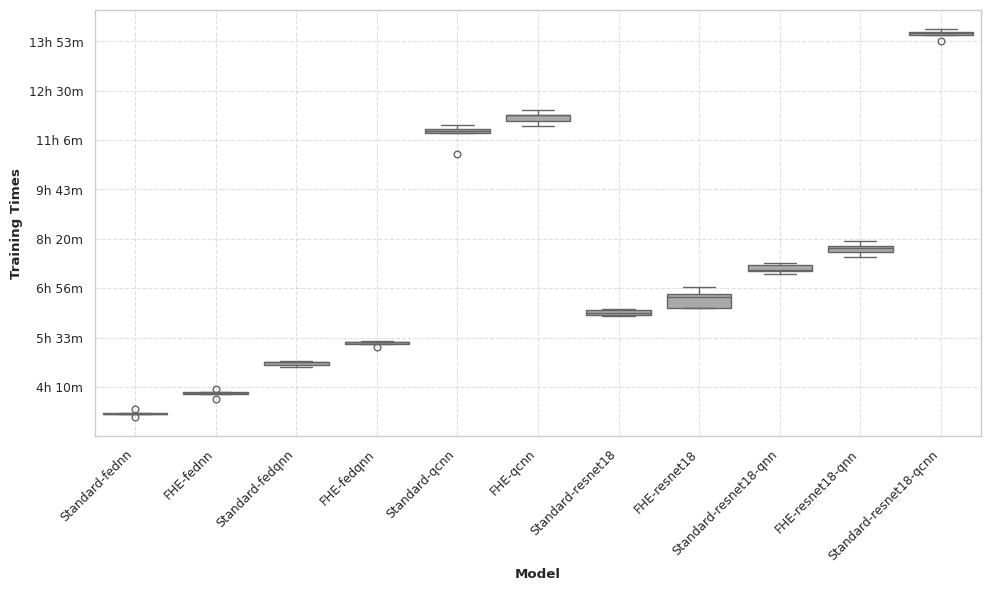

{
    "6": {
        "('Model', '')": "Standard-fednn",
        "('Training Times', 'count')": 0.0833333333,
        "('Training Times', 'mean')": 205.8880865645,
        "('Training Times', 'std')": 5.0564959565,
        "('Training Times', 'min')": 199.7611806393,
        "('Training Times', '25%')": 204.3920612375,
        "('Training Times', '50%')": 205.0577064435,
        "('Training Times', '75%')": 206.503871878,
        "('Training Times', 'max')": 213.7256126245
    },
    "0": {
        "('Model', '')": "FHE-fednn",
        "('Training Times', 'count')": 0.0833333333,
        "('Training Times', 'mean')": 239.0405802751,
        "('Training Times', 'std')": 6.0849283966,
        "('Training Times', 'min')": 229.7580428004,
        "('Training Times', '25%')": 238.110058705,
        "('Training Times', '50%')": 239.8553578734,
        "('Training Times', '75%')": 240.8896041234,
        "('Training Times', 'max')": 246.589837873
    },
    "7": {
        "('Model', '')": "Sta

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter


def format_time(seconds, _):
    if seconds < 60:
        return f"{int(seconds)}s"
    elif seconds < 3600:
        minutes = seconds // 60
        seconds = seconds % 60
        return f"{int(minutes)}m {int(seconds)}s"
    else:
        hours = seconds // 3600
        minutes = (seconds % 3600) // 60
        return f"{int(hours)}h {int(minutes)}m"


def display_boxplot(
    metrics_df: pd.DataFrame, metric_label: str, formatter: FuncFormatter = None
):
    sns.set_theme(style="whitegrid", context="paper")

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(x="Model", y=metric_label, data=metrics_df, color=COLOR)

    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Model", fontweight="bold")
    plt.ylabel(metric_label, fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.6)

    if formatter:
        ax.yaxis.set_major_formatter(FuncFormatter(formatter))
    # Display the plot
    plt.tight_layout()
    plt.show()


metric_label = "Training Times"
df = get_dataframe_from_metrics_data(training_times, metric_label)
display_boxplot(df[df["Model"] != "FHE-resnet18-qcnn"], metric_label, format_time)
stats = (
    (df.groupby("Model").describe() / 60)
    .reset_index()
    .sort_values((metric_label, "mean"))
)

stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

### Client Round Times

In [15]:
client_round_times = get_metric_by_model_type(
    runs, groups, "client_metric", "client_round_time"
)

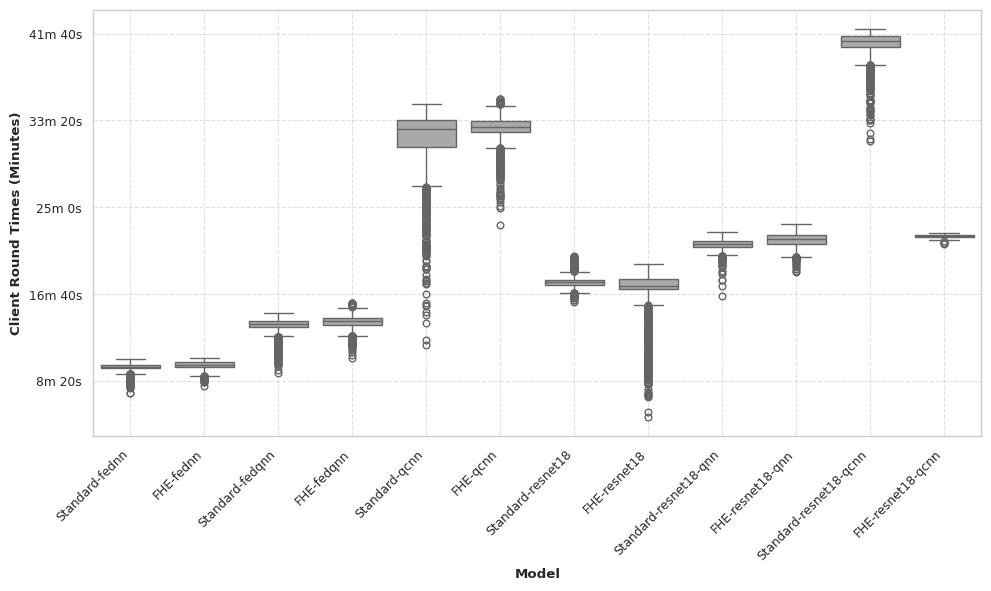

{
    "6": {
        "('Model', '')": "Standard-fednn",
        "('Client Round Times (Minutes)', 'count')": 33.3333333333,
        "('Client Round Times (Minutes)', 'mean')": 9.7077621938,
        "('Client Round Times (Minutes)', 'std')": 0.3917332931,
        "('Client Round Times (Minutes)', 'min')": 7.2126805862,
        "('Client Round Times (Minutes)', '25%')": 9.5722949882,
        "('Client Round Times (Minutes)', '50%')": 9.7388438026,
        "('Client Round Times (Minutes)', '75%')": 9.9362092863,
        "('Client Round Times (Minutes)', 'max')": 10.4672650019
    },
    "0": {
        "('Model', '')": "FHE-fednn",
        "('Client Round Times (Minutes)', 'count')": 33.3333333333,
        "('Client Round Times (Minutes)', 'mean')": 9.8952131211,
        "('Client Round Times (Minutes)', 'std')": 0.3826520966,
        "('Client Round Times (Minutes)', 'min')": 7.8437304099,
        "('Client Round Times (Minutes)', '25%')": 9.6624839524,
        "('Client Round Times (Minu

In [16]:
metric_label = "Client Round Times (Minutes)"
df = get_dataframe_from_metrics_data(client_round_times, metric_label)
display_boxplot(df, metric_label, format_time)
stats = (
    (df.groupby("Model").describe() / 60)
    .reset_index()
    .sort_values((metric_label, "mean"))
)
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

### Server Round Times

In [17]:
round_times = get_metric_by_model_type(runs, groups, "server_metric", "round_time")

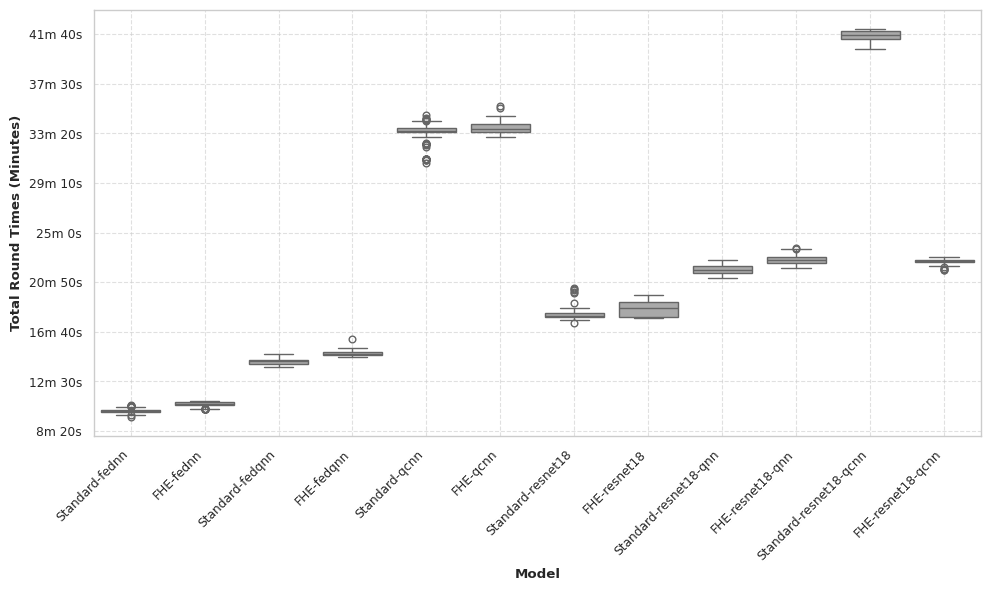

{
    "6": {
        "('Model', '')": "Standard-fednn",
        "('Total Round Times (Minutes)', 'count')": 1.6666666667,
        "('Total Round Times (Minutes)', 'mean')": 10.0163427968,
        "('Total Round Times (Minutes)', 'std')": 0.2242036104,
        "('Total Round Times (Minutes)', 'min')": 9.5209356546,
        "('Total Round Times (Minutes)', '25%')": 9.9352502704,
        "('Total Round Times (Minutes)', '50%')": 9.9850816747,
        "('Total Round Times (Minutes)', '75%')": 10.1119956682,
        "('Total Round Times (Minutes)', 'max')": 10.4755758524
    },
    "0": {
        "('Model', '')": "FHE-fednn",
        "('Total Round Times (Minutes)', 'count')": 1.6666666667,
        "('Total Round Times (Minutes)', 'mean')": 10.5772877299,
        "('Total Round Times (Minutes)', 'std')": 0.2158906305,
        "('Total Round Times (Minutes)', 'min')": 10.1357677897,
        "('Total Round Times (Minutes)', '25%')": 10.5172938436,
        "('Total Round Times (Minutes)', '50%

In [18]:
metric_label = "Total Round Times (Minutes)"
df = get_dataframe_from_metrics_data(round_times, metric_label)
display_boxplot(df, metric_label, format_time)
stats = (
    (df.groupby("Model").describe() / 60)
    .reset_index()
    .sort_values((metric_label, "mean"))
)
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

## CPU Usage

In [19]:
client_cpu_usage = get_metric_by_model_type(
    runs, groups, "system_metric", "client_cpu_percentage"
)

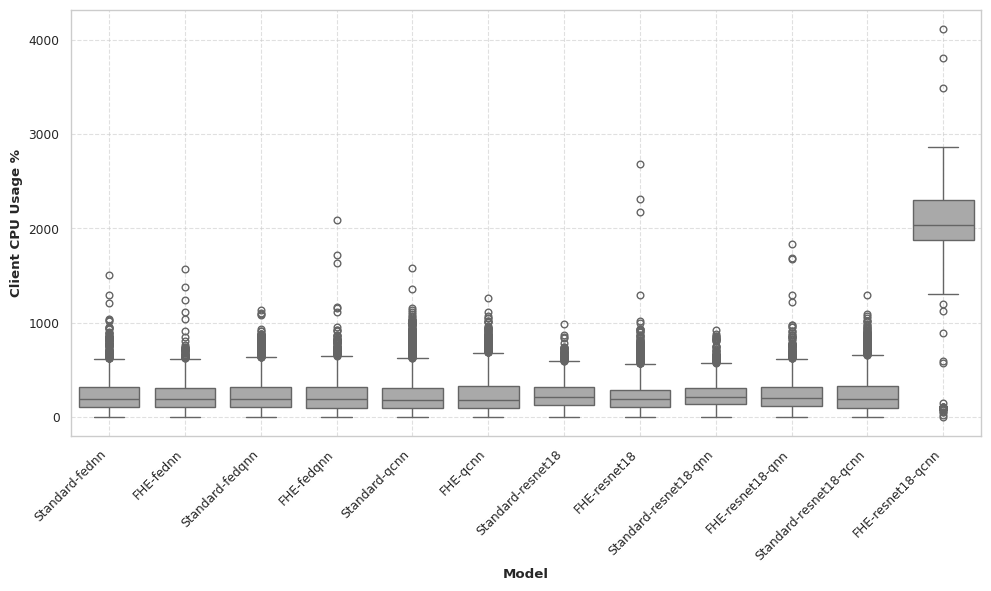

{
    "FHE-fednn": {
        "('Client CPU Usage %', 'count')": 2147.0,
        "('Client CPU Usage %', 'mean')": 225.4363763391,
        "('Client CPU Usage %', 'std')": 159.0720639604,
        "('Client CPU Usage %', 'min')": 1.9,
        "('Client CPU Usage %', '25%')": 105.9,
        "('Client CPU Usage %', '50%')": 191.8,
        "('Client CPU Usage %', '75%')": 311.7,
        "('Client CPU Usage %', 'max')": 1565.9
    },
    "FHE-fedqnn": {
        "('Client CPU Usage %', 'count')": 2192.0,
        "('Client CPU Usage %', 'mean')": 230.5343978102,
        "('Client CPU Usage %', 'std')": 183.9176149905,
        "('Client CPU Usage %', 'min')": 2.0,
        "('Client CPU Usage %', '25%')": 99.9,
        "('Client CPU Usage %', '50%')": 185.8,
        "('Client CPU Usage %', '75%')": 319.525,
        "('Client CPU Usage %', 'max')": 2086.1
    },
    "FHE-qcnn": {
        "('Client CPU Usage %', 'count')": 2371.0,
        "('Client CPU Usage %', 'mean')": 239.1122311261,
        "

In [20]:
metric_label = "Client CPU Usage %"
df = get_dataframe_from_metrics_data(client_cpu_usage, metric_label)
df = df[df[metric_label] > 0]
display_boxplot(df, metric_label)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

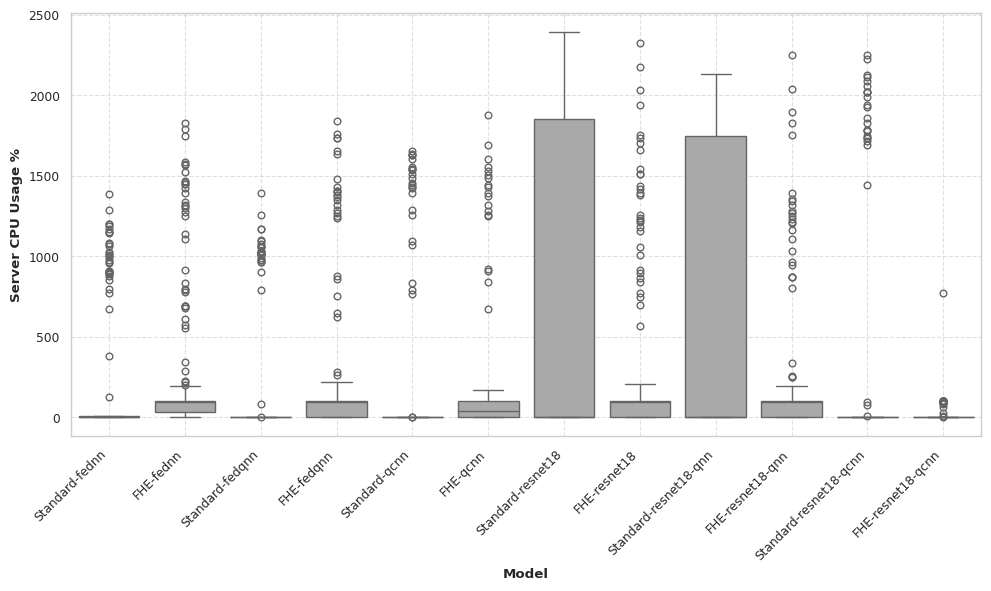

{
    "FHE-fednn": {
        "('Server CPU Usage %', 'count')": 431.0,
        "('Server CPU Usage %', 'mean')": 157.6800464037,
        "('Server CPU Usage %', 'std')": 316.5063001261,
        "('Server CPU Usage %', 'min')": 2.0,
        "('Server CPU Usage %', '25%')": 33.95,
        "('Server CPU Usage %', '50%')": 97.9,
        "('Server CPU Usage %', '75%')": 99.9,
        "('Server CPU Usage %', 'max')": 1824.1
    },
    "FHE-fedqnn": {
        "('Server CPU Usage %', 'count')": 331.0,
        "('Server CPU Usage %', 'mean')": 155.1018126888,
        "('Server CPU Usage %', 'std')": 342.557688656,
        "('Server CPU Usage %', 'min')": 2.0,
        "('Server CPU Usage %', '25%')": 2.0,
        "('Server CPU Usage %', '50%')": 97.9,
        "('Server CPU Usage %', '75%')": 99.9,
        "('Server CPU Usage %', 'max')": 1839.8
    },
    "FHE-qcnn": {
        "('Server CPU Usage %', 'count')": 224.0,
        "('Server CPU Usage %', 'mean')": 154.4517857143,
        "('Server CP

In [21]:
server_cpu_usage = get_metric_by_model_type(
    runs, groups, "system_metric", "server_cpu_percentage"
)
metric_label = "Server CPU Usage %"
df = get_dataframe_from_metrics_data(server_cpu_usage, metric_label)
df = df[df[metric_label] > 0]
display_boxplot(df, metric_label)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

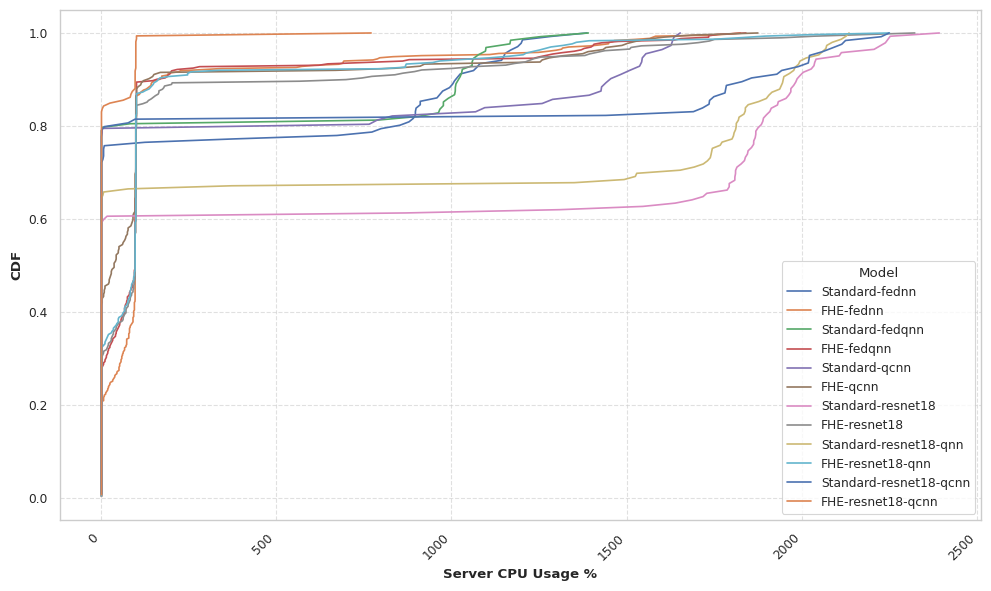

In [22]:
def display_cdf_plot(metrics_df: pd.DataFrame, metric_label: str):
    sns.set_theme(style="whitegrid", context="paper")

    fig, ax = plt.subplots(figsize=(10, 6))

    for model in metrics_df["Model"].unique():
        data = metrics_df[metrics_df["Model"] == model][metric_label]
        # Sort data for CDF calculation
        data_sorted = np.sort(data)
        cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
        ax.plot(data_sorted, cdf, label=model)

    plt.xticks(rotation=45, ha="right")
    plt.xlabel(metric_label, fontweight="bold")
    plt.ylabel("CDF", fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.6)

    ax.legend(title="Model")

    # Display the plot
    plt.tight_layout()
    plt.show()


# Example usage:
display_cdf_plot(df, metric_label)

# RAM Usage

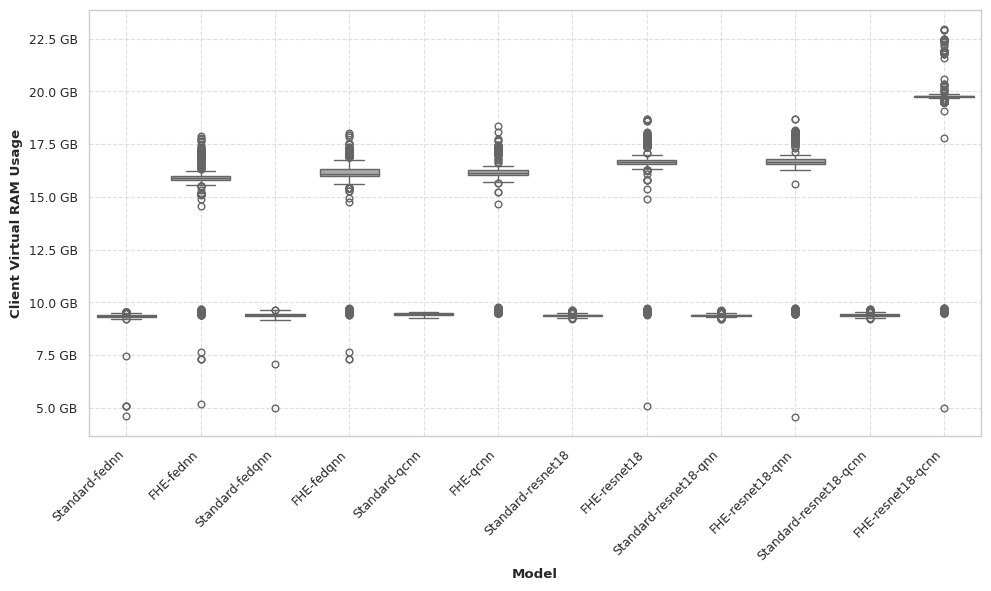

{
    "FHE-fednn": {
        "('Client Virtual RAM Usage', 'count')": 2400.0,
        "('Client Virtual RAM Usage', 'mean')": 15716.3012516667,
        "('Client Virtual RAM Usage', 'std')": 1428.3225833409,
        "('Client Virtual RAM Usage', 'min')": 5157.23,
        "('Client Virtual RAM Usage', '25%')": 15813.679,
        "('Client Virtual RAM Usage', '50%')": 15896.773,
        "('Client Virtual RAM Usage', '75%')": 15990.617,
        "('Client Virtual RAM Usage', 'max')": 17883.742
    },
    "FHE-fedqnn": {
        "('Client Virtual RAM Usage', 'count')": 2436.0,
        "('Client Virtual RAM Usage', 'mean')": 15859.4135500821,
        "('Client Virtual RAM Usage', 'std')": 1525.3972201394,
        "('Client Virtual RAM Usage', 'min')": 7307.066,
        "('Client Virtual RAM Usage', '25%')": 15998.152,
        "('Client Virtual RAM Usage', '50%')": 16078.23,
        "('Client Virtual RAM Usage', '75%')": 16311.031,
        "('Client Virtual RAM Usage', 'max')": 18019.582
    

In [23]:
def format_usage(usage_mb, _):
    if usage_mb < 1_000:
        return f"{int(usage_mb)} MB"
    else:
        gb = round(usage_mb / 1_000, 2)
        return f"{gb} GB"


client_vir_ram_usage = get_metric_by_model_type(
    runs, groups, "system_metric", "client_virtual_memory_mb"
)
metric_label = "Client Virtual RAM Usage"
df = get_dataframe_from_metrics_data(client_vir_ram_usage, metric_label)

display_boxplot(df, metric_label, format_usage)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

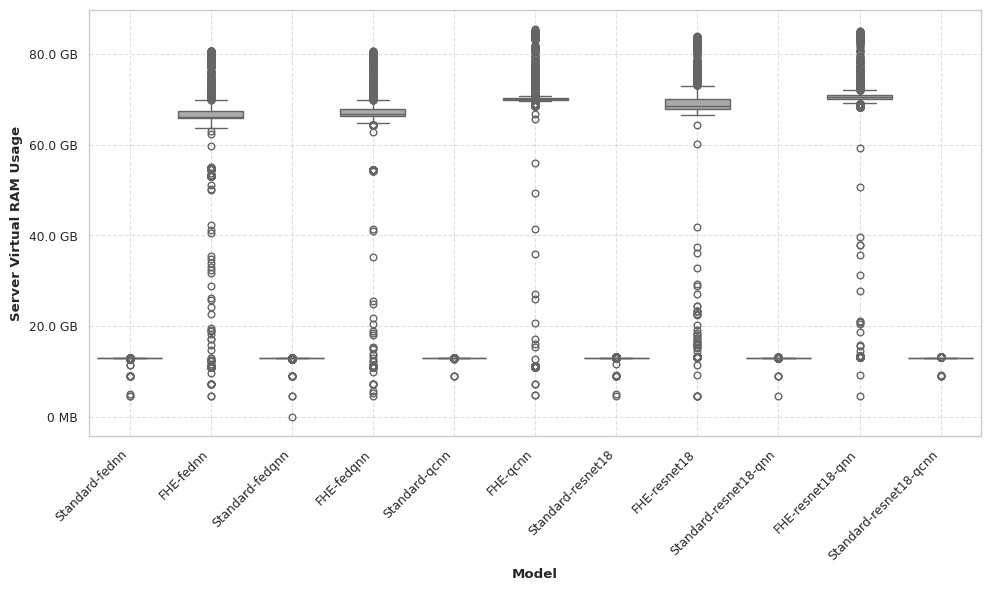

{
    "FHE-fednn": {
        "('Server Virtual RAM Usage', 'count')": 2491.0,
        "('Server Virtual RAM Usage', 'mean')": 64245.4867145725,
        "('Server Virtual RAM Usage', 'std')": 13490.3089580677,
        "('Server Virtual RAM Usage', 'min')": 4529.133,
        "('Server Virtual RAM Usage', '25%')": 65842.348,
        "('Server Virtual RAM Usage', '50%')": 66133.801,
        "('Server Virtual RAM Usage', '75%')": 67430.93,
        "('Server Virtual RAM Usage', 'max')": 80736.859
    },
    "FHE-fedqnn": {
        "('Server Virtual RAM Usage', 'count')": 2493.0,
        "('Server Virtual RAM Usage', 'mean')": 64861.9026197353,
        "('Server Virtual RAM Usage', 'std')": 12695.2675006809,
        "('Server Virtual RAM Usage', 'min')": 4625.793,
        "('Server Virtual RAM Usage', '25%')": 66415.648,
        "('Server Virtual RAM Usage', '50%')": 66683.117,
        "('Server Virtual RAM Usage', '75%')": 67753.184,
        "('Server Virtual RAM Usage', 'max')": 80540.75
  

In [24]:
server_vir_ram_usage = get_metric_by_model_type(
    runs, groups, "system_metric", "server_virtual_memory_mb"
)
metric_label = "Server Virtual RAM Usage"
df = get_dataframe_from_metrics_data(server_vir_ram_usage, metric_label)

display_boxplot(df[df["Model"] != "FHE-resnet18-qcnn"], metric_label, format_usage)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

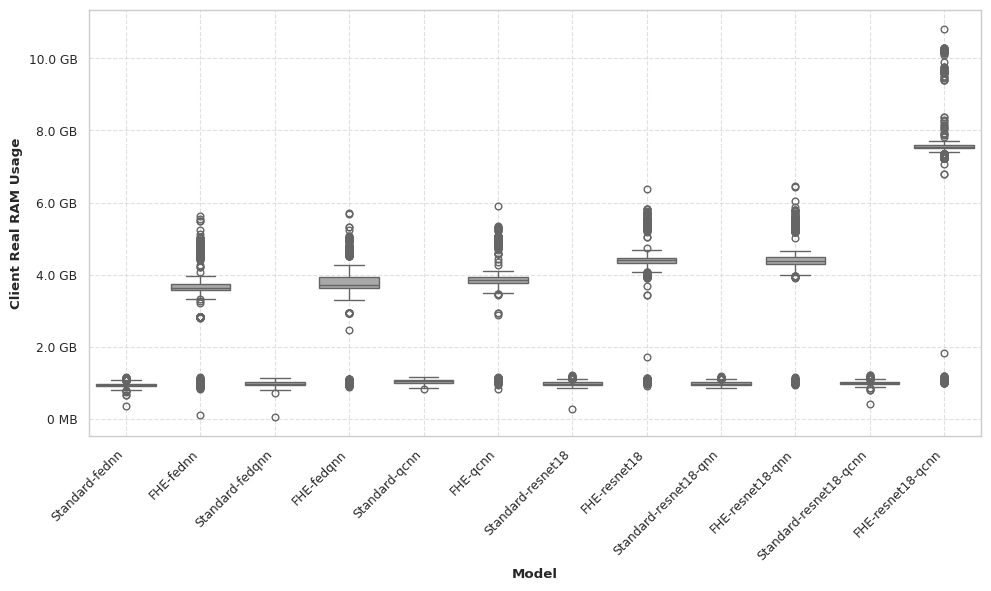

{
    "FHE-fednn": {
        "('Client Real RAM Usage', 'count')": 2398.0,
        "('Client Real RAM Usage', 'mean')": 3628.7394783153,
        "('Client Real RAM Usage', 'std')": 702.1221410536,
        "('Client Real RAM Usage', 'min')": 89.5,
        "('Client Real RAM Usage', '25%')": 3566.60025,
        "('Client Real RAM Usage', '50%')": 3638.545,
        "('Client Real RAM Usage', '75%')": 3737.02575,
        "('Client Real RAM Usage', 'max')": 5612.051
    },
    "FHE-fedqnn": {
        "('Client Real RAM Usage', 'count')": 2423.0,
        "('Client Real RAM Usage', 'mean')": 3718.9988547255,
        "('Client Real RAM Usage', 'std')": 672.7972302876,
        "('Client Real RAM Usage', 'min')": 886.359,
        "('Client Real RAM Usage', '25%')": 3628.0525,
        "('Client Real RAM Usage', '50%')": 3704.289,
        "('Client Real RAM Usage', '75%')": 3926.043,
        "('Client Real RAM Usage', 'max')": 5706.621
    },
    "FHE-qcnn": {
        "('Client Real RAM Usage', 'c

In [25]:
client_real_ram_usage = get_metric_by_model_type(
    runs, groups, "system_metric", "client_real_memory_mb"
)
metric_label = "Client Real RAM Usage"
df = get_dataframe_from_metrics_data(client_real_ram_usage, metric_label)

display_boxplot(df, metric_label, format_usage)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

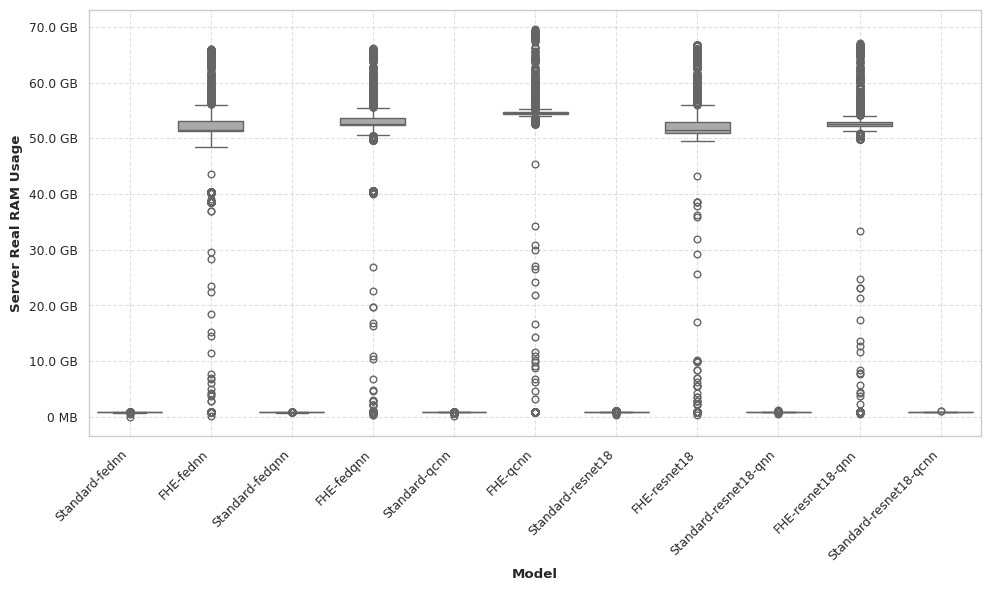

{
    "FHE-fednn": {
        "('Server Real RAM Usage', 'count')": 2498.0,
        "('Server Real RAM Usage', 'mean')": 50284.3759547638,
        "('Server Real RAM Usage', 'std')": 11859.1426646887,
        "('Server Real RAM Usage', 'min')": 119.0,
        "('Server Real RAM Usage', '25%')": 51249.21275,
        "('Server Real RAM Usage', '50%')": 51454.867,
        "('Server Real RAM Usage', '75%')": 53189.1035,
        "('Server Real RAM Usage', 'max')": 66019.551
    },
    "FHE-fedqnn": {
        "('Server Real RAM Usage', 'count')": 2488.0,
        "('Server Real RAM Usage', 'mean')": 51260.0637471865,
        "('Server Real RAM Usage', 'std')": 11280.5717122655,
        "('Server Real RAM Usage', 'min')": 375.684,
        "('Server Real RAM Usage', '25%')": 52377.875,
        "('Server Real RAM Usage', '50%')": 52613.887,
        "('Server Real RAM Usage', '75%')": 53640.086,
        "('Server Real RAM Usage', 'max')": 66229.836
    },
    "FHE-qcnn": {
        "('Server Real R

In [26]:
server_real_ram_usage = get_metric_by_model_type(
    runs, groups, "system_metric", "server_real_memory_mb"
)
metric_label = "Server Real RAM Usage"
df = get_dataframe_from_metrics_data(server_real_ram_usage, metric_label)
display_boxplot(df[df["Model"] != "FHE-resnet18-qcnn"], metric_label, format_usage)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

# FHE

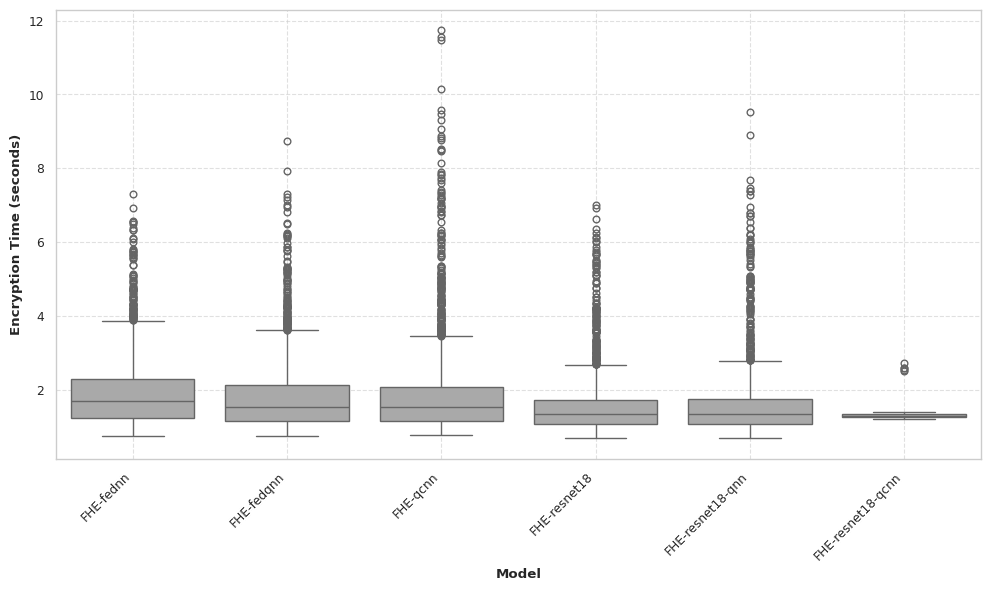

{
    "FHE-fednn": {
        "('Encryption Time (seconds)', 'count')": 2000.0,
        "('Encryption Time (seconds)', 'mean')": 1.8867589698,
        "('Encryption Time (seconds)', 'std')": 0.9276680292,
        "('Encryption Time (seconds)', 'min')": 0.7516534328,
        "('Encryption Time (seconds)', '25%')": 1.2232295871,
        "('Encryption Time (seconds)', '50%')": 1.6776663065,
        "('Encryption Time (seconds)', '75%')": 2.2786102295,
        "('Encryption Time (seconds)', 'max')": 7.3121678829
    },
    "FHE-fedqnn": {
        "('Encryption Time (seconds)', 'count')": 2000.0,
        "('Encryption Time (seconds)', 'mean')": 1.8180749663,
        "('Encryption Time (seconds)', 'std')": 0.989605596,
        "('Encryption Time (seconds)', 'min')": 0.7489628792,
        "('Encryption Time (seconds)', '25%')": 1.1486233473,
        "('Encryption Time (seconds)', '50%')": 1.5325329304,
        "('Encryption Time (seconds)', '75%')": 2.1361057162,
        "('Encryption Time (se

In [27]:
client_encryption_time = get_metric_by_model_type(
    runs, groups, "client_metric", "encryption_time"
)
metric_label = "Encryption Time (seconds)"
df = get_dataframe_from_metrics_data(client_encryption_time, metric_label)

display_boxplot(df, metric_label)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

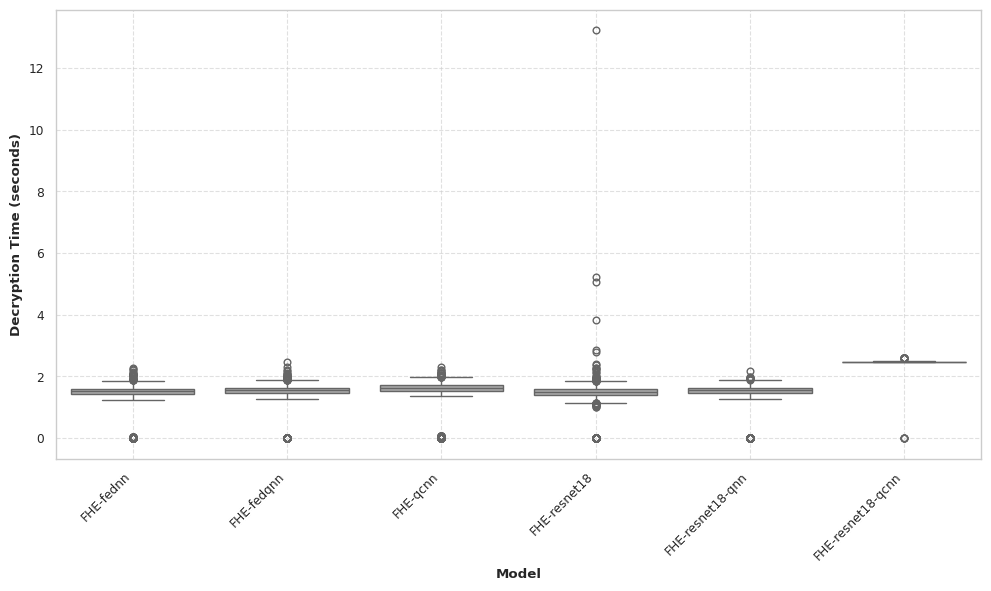

{
    "FHE-fednn": {
        "('Decryption Time (seconds)', 'count')": 2100.0,
        "('Decryption Time (seconds)', 'mean')": 1.4658776727,
        "('Decryption Time (seconds)', 'std')": 0.3518127098,
        "('Decryption Time (seconds)', 'min')": 0.0009038448,
        "('Decryption Time (seconds)', '25%')": 1.4362022281,
        "('Decryption Time (seconds)', '50%')": 1.5377664566,
        "('Decryption Time (seconds)', '75%')": 1.6084440351,
        "('Decryption Time (seconds)', 'max')": 2.2766234875
    },
    "FHE-fedqnn": {
        "('Decryption Time (seconds)', 'count')": 2100.0,
        "('Decryption Time (seconds)', 'mean')": 1.4884455793,
        "('Decryption Time (seconds)', 'std')": 0.3559202308,
        "('Decryption Time (seconds)', 'min')": 0.000805378,
        "('Decryption Time (seconds)', '25%')": 1.4694334865,
        "('Decryption Time (seconds)', '50%')": 1.5547155142,
        "('Decryption Time (seconds)', '75%')": 1.6320490241,
        "('Decryption Time (se

In [28]:
client_decryption_time = get_metric_by_model_type(
    runs, groups, "client_metric", "decryption_time"
)
metric_label = "Decryption Time (seconds)"
df = get_dataframe_from_metrics_data(client_decryption_time, metric_label)

display_boxplot(df, metric_label)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


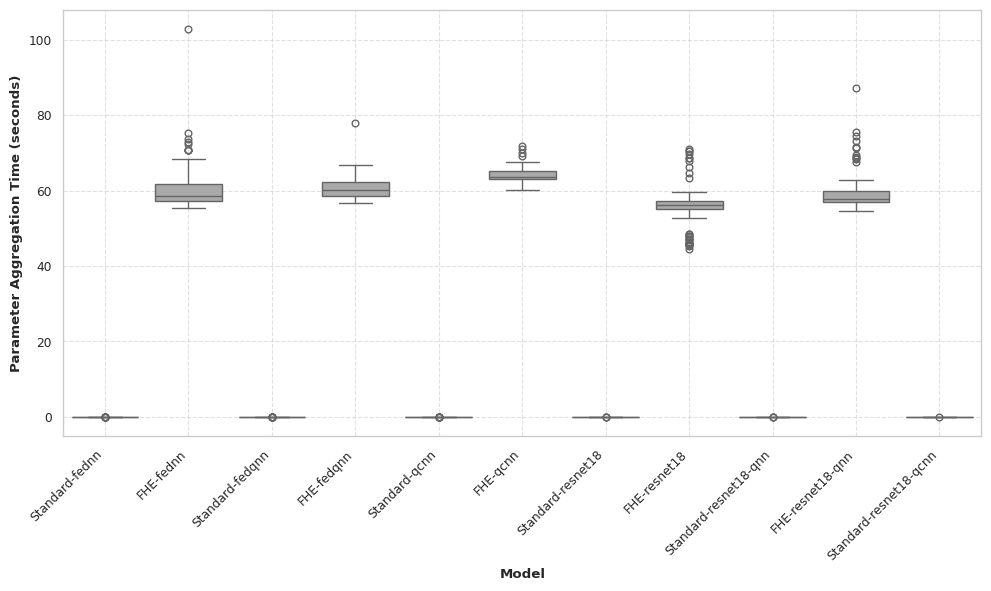

{
    "FHE-fednn": {
        "('Parameter Aggregation Time (seconds)', 'count')": 100.0,
        "('Parameter Aggregation Time (seconds)', 'mean')": 60.494256916,
        "('Parameter Aggregation Time (seconds)', 'std')": 6.1601190561,
        "('Parameter Aggregation Time (seconds)', 'min')": 55.2537150383,
        "('Parameter Aggregation Time (seconds)', '25%')": 57.3378408551,
        "('Parameter Aggregation Time (seconds)', '50%')": 58.4464248419,
        "('Parameter Aggregation Time (seconds)', '75%')": 61.822103858,
        "('Parameter Aggregation Time (seconds)', 'max')": 102.7923774719
    },
    "FHE-fedqnn": {
        "('Parameter Aggregation Time (seconds)', 'count')": 100.0,
        "('Parameter Aggregation Time (seconds)', 'mean')": 60.6507138681,
        "('Parameter Aggregation Time (seconds)', 'std')": 2.9178090164,
        "('Parameter Aggregation Time (seconds)', 'min')": 56.8110821247,
        "('Parameter Aggregation Time (seconds)', '25%')": 58.595451653,
     

In [29]:
server_aggregation_time = get_metric_by_model_type(
    runs, groups, "server_metric", "parameter_aggregation_time"
)
metric_label = "Parameter Aggregation Time (seconds)"
df = get_dataframe_from_metrics_data(server_aggregation_time, metric_label)

display_boxplot(df[df["Model"] != "FHE-resnet18-qcnn"], metric_label)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

# Communication Overhead

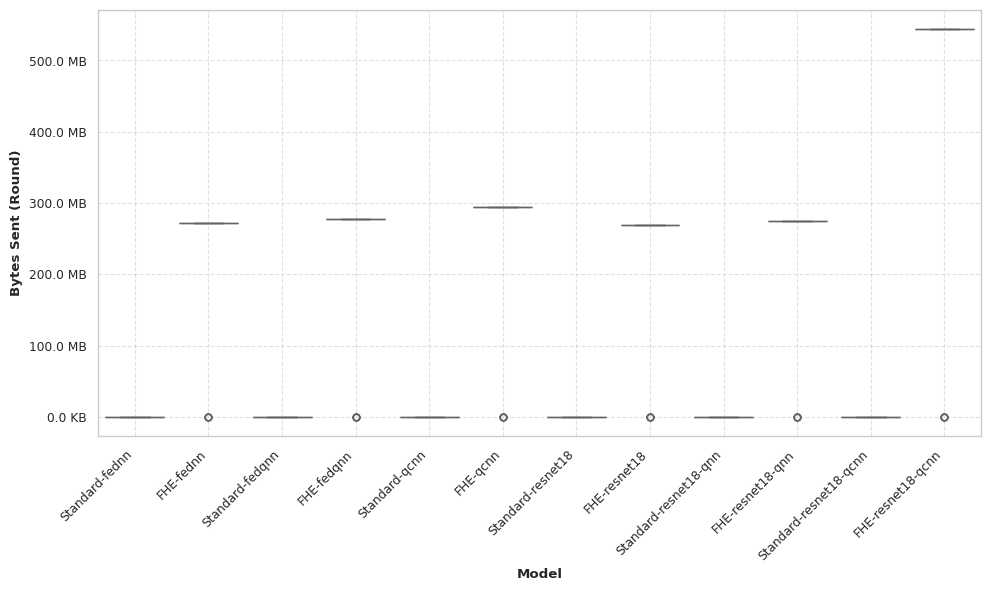

{
    "FHE-fednn": {
        "('Bytes Sent (Round)', 'count')": 100.0,
        "('Bytes Sent (Round)', 'mean')": 257764098.1,
        "('Bytes Sent (Round)', 'std')": 59430876.19839907,
        "('Bytes Sent (Round)', 'min')": 9435.0,
        "('Bytes Sent (Round)', '25%')": 271330133.0,
        "('Bytes Sent (Round)', '50%')": 271330133.0,
        "('Bytes Sent (Round)', '75%')": 271330133.0,
        "('Bytes Sent (Round)', 'max')": 271330133.0
    },
    "FHE-fedqnn": {
        "('Bytes Sent (Round)', 'count')": 100.0,
        "('Bytes Sent (Round)', 'mean')": 263248506.95,
        "('Bytes Sent (Round)', 'std')": 60695293.31232246,
        "('Bytes Sent (Round)', 'min')": 10004.0,
        "('Bytes Sent (Round)', '25%')": 277103165.0,
        "('Bytes Sent (Round)', '50%')": 277103165.0,
        "('Bytes Sent (Round)', '75%')": 277103165.0,
        "('Bytes Sent (Round)', 'max')": 277103165.0
    },
    "FHE-qcnn": {
        "('Bytes Sent (Round)', 'count')": 100.0,
        "('Bytes 

In [30]:
def format_bytes(bytes, _):
    if bytes < 1_000_000:
        value = round(int(bytes) * 0.001, 2)
        return f"{value} KB"
    if bytes < 1_000_000_000:
        value = round(int(bytes) * 0.000001, 2)
        return f"{value} MB"
    else:
        value = round(int(bytes) * 1e-9, 2)
        return f"{value} GB"


server_bytes_sent = get_metric_by_model_type(
    runs, groups, "server_metric", "Bytes Sent (Round)"
)
metric_label = "Bytes Sent (Round)"
df = get_dataframe_from_metrics_data(server_bytes_sent, metric_label)

display_boxplot(df, metric_label, format_bytes)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

In [31]:
stats = df.groupby("Model").describe()[("Bytes Sent (Round)", "max")].reset_index()
stats["MB Sent (Round)"] = stats["Bytes Sent (Round)"] / (1024**2)
stats["Model"] = pd.Categorical(stats["Model"], categories=KEY_ORDER, ordered=True)
stats = stats.sort_values("Model").reset_index(drop=True)
stats

,Model,Bytes Sent (Round),MB Sent (Round)
,,max,
0,Standard-fednn,9435.0,0.008998
1,FHE-fednn,271330133.0,258.760579
2,Standard-fedqnn,10004.0,0.009541
3,FHE-fedqnn,277103165.0,264.266171
4,Standard-qcnn,10520.0,0.010033
5,FHE-qcnn,294028480.0,280.407410
6,Standard-resnet18,8573.0,0.008176
7,FHE-resnet18,269230755.0,256.758456
8,Standard-resnet18-qnn,9142.0,0.008718


In [32]:
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

{
    "0": {
        "('Model', '')": "Standard-fednn",
        "('Bytes Sent (Round)', 'max')": 9435.0,
        "('MB Sent (Round)', '')": 0.0089979172
    },
    "1": {
        "('Model', '')": "FHE-fednn",
        "('Bytes Sent (Round)', 'max')": 271330133.0,
        "('MB Sent (Round)', '')": 258.7605791092
    },
    "2": {
        "('Model', '')": "Standard-fedqnn",
        "('Bytes Sent (Round)', 'max')": 10004.0,
        "('MB Sent (Round)', '')": 0.0095405579
    },
    "3": {
        "('Model', '')": "FHE-fedqnn",
        "('Bytes Sent (Round)', 'max')": 277103165.0,
        "('MB Sent (Round)', '')": 264.2661714554
    },
    "4": {
        "('Model', '')": "Standard-qcnn",
        "('Bytes Sent (Round)', 'max')": 10520.0,
        "('MB Sent (Round)', '')": 0.0100326538
    },
    "5": {
        "('Model', '')": "FHE-qcnn",
        "('Bytes Sent (Round)', 'max')": 294028480.0,
        "('MB Sent (Round)', '')": 280.407409668
    },
    "6": {
        "('Model', '')": "Standa

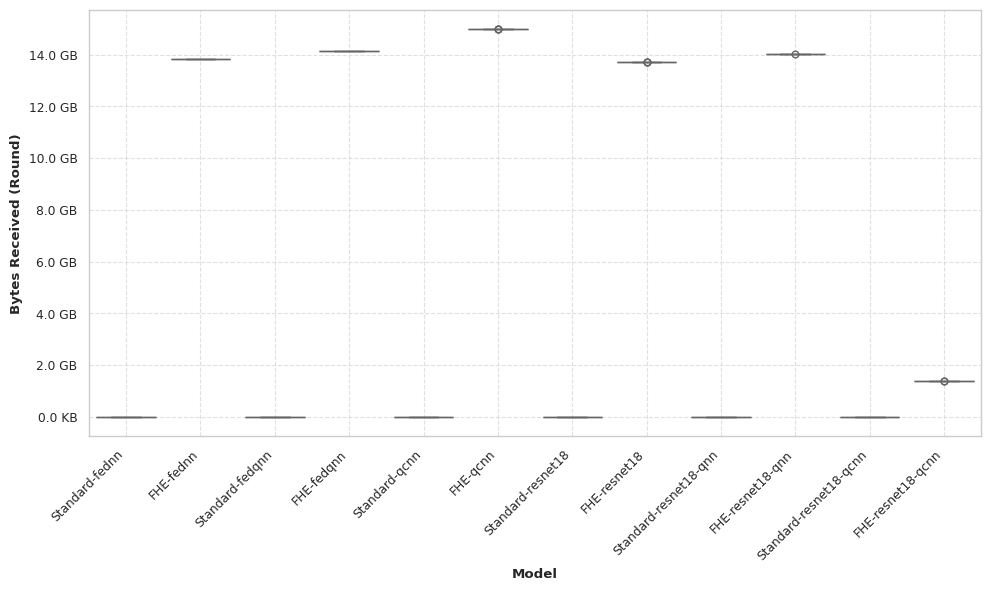

{
    "FHE-fednn": {
        "('Bytes Received (Round)', 'count')": 100.0,
        "('Bytes Received (Round)', 'mean')": 13825695393.69,
        "('Bytes Received (Round)', 'std')": 42770.1394692145,
        "('Bytes Received (Round)', 'min')": 13825612716.0,
        "('Bytes Received (Round)', '25%')": 13825665007.75,
        "('Bytes Received (Round)', '50%')": 13825692044.5,
        "('Bytes Received (Round)', '75%')": 13825722685.0,
        "('Bytes Received (Round)', 'max')": 13825791285.0
    },
    "FHE-fedqnn": {
        "('Bytes Received (Round)', 'count')": 100.0,
        "('Bytes Received (Round)', 'mean')": 14119865611.66,
        "('Bytes Received (Round)', 'std')": 44829.9446999706,
        "('Bytes Received (Round)', 'min')": 14119770322.0,
        "('Bytes Received (Round)', '25%')": 14119831900.25,
        "('Bytes Received (Round)', '50%')": 14119868942.5,
        "('Bytes Received (Round)', '75%')": 14119894966.75,
        "('Bytes Received (Round)', 'max')": 1411997

In [33]:
server_bytes_received = get_metric_by_model_type(
    runs, groups, "server_metric", "Bytes Received (Round)"
)
metric_label = "Bytes Received (Round)"
df = get_dataframe_from_metrics_data(server_bytes_received, metric_label)

display_boxplot(df, metric_label, format_bytes)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

In [34]:
stats = df.groupby("Model").describe()[("Bytes Received (Round)", "max")].reset_index()
stats["MB Received (Round)"] = stats["Bytes Received (Round)"] / (1024**2)
stats["Model"] = pd.Categorical(stats["Model"], categories=KEY_ORDER, ordered=True)
stats = stats.sort_values("Model").reset_index(drop=True)
stats

,Model,Bytes Received (Round),MB Received (Round)
,,max,
0,Standard-fednn,1.887000e+05,0.179958
1,FHE-fednn,1.382579e+10,13185.302052
2,Standard-fedqnn,2.000800e+05,0.190811
3,FHE-fedqnn,1.411998e+10,13465.861021
4,Standard-qcnn,2.104000e+05,0.200653
5,FHE-qcnn,1.498237e+10,14288.304976
6,Standard-resnet18,1.714600e+05,0.163517
7,FHE-resnet18,1.371886e+10,13083.326189
8,Standard-resnet18-qnn,1.828400e+05,0.174370


In [35]:
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

{
    "0": {
        "('Model', '')": "Standard-fednn",
        "('Bytes Received (Round)', 'max')": 188700.0,
        "('MB Received (Round)', '')": 0.1799583435
    },
    "1": {
        "('Model', '')": "FHE-fednn",
        "('Bytes Received (Round)', 'max')": 13825791285.0,
        "('MB Received (Round)', '')": 13185.3020524979
    },
    "2": {
        "('Model', '')": "Standard-fedqnn",
        "('Bytes Received (Round)', 'max')": 200080.0,
        "('MB Received (Round)', '')": 0.1908111572
    },
    "3": {
        "('Model', '')": "FHE-fedqnn",
        "('Bytes Received (Round)', 'max')": 14119978686.0,
        "('MB Received (Round)', '')": 13465.8610210419
    },
    "4": {
        "('Model', '')": "Standard-qcnn",
        "('Bytes Received (Round)', 'max')": 210400.0,
        "('MB Received (Round)', '')": 0.2006530762
    },
    "5": {
        "('Model', '')": "FHE-qcnn",
        "('Bytes Received (Round)', 'max')": 14982373678.0,
        "('MB Received (Round)', '')": 14

In [36]:
server_total_bytes_sent = get_metric_by_model_type(
    runs, groups, "server_metric", "Total Bytes Sent"
)
metric_label = "Total Bytes Sent"
df = get_dataframe_from_metrics_data(server_total_bytes_sent, metric_label)

stats = df.groupby("Model").describe()[("Total Bytes Sent", "max")].reset_index()
stats["MB Total Bytes Sent"] = stats["Total Bytes Sent"] / (1024**2)
stats["Model"] = pd.Categorical(stats["Model"], categories=KEY_ORDER, ordered=True)
stats = stats.sort_values("Model").reset_index(drop=True)
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

{
    "0": {
        "('Model', '')": "Standard-fednn",
        "('Total Bytes Sent', 'max')": 188700.0,
        "('MB Total Bytes Sent', '')": 0.1799583435
    },
    "1": {
        "('Model', '')": "FHE-fednn",
        "('Total Bytes Sent', 'max')": 5155281962.0,
        "('MB Total Bytes Sent', '')": 4916.4600009918
    },
    "2": {
        "('Model', '')": "Standard-fedqnn",
        "('Total Bytes Sent', 'max')": 200080.0,
        "('MB Total Bytes Sent', '')": 0.1908111572
    },
    "3": {
        "('Model', '')": "FHE-fedqnn",
        "('Total Bytes Sent', 'max')": 5264970139.0,
        "('MB Total Bytes Sent', '')": 5021.0667982101
    },
    "4": {
        "('Model', '')": "Standard-qcnn",
        "('Total Bytes Sent', 'max')": 210400.0,
        "('MB Total Bytes Sent', '')": 0.2006530762
    },
    "5": {
        "('Model', '')": "FHE-qcnn",
        "('Total Bytes Sent', 'max')": 5586551640.0,
        "('MB Total Bytes Sent', '')": 5327.7508163452
    },
    "6": {
        "

In [37]:
server_total_bytes_received = get_metric_by_model_type(
    runs, groups, "server_metric", "Total Bytes Received"
)
metric_label = "Total Bytes Received"
df = get_dataframe_from_metrics_data(server_total_bytes_received, metric_label)

stats = df.groupby("Model").describe()[("Total Bytes Received", "max")].reset_index()
stats["MB Total Bytes Received"] = stats["Total Bytes Received"] / (1024**2)
stats["Model"] = pd.Categorical(stats["Model"], categories=KEY_ORDER, ordered=True)
stats = stats.sort_values("Model").reset_index(drop=True)
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

{
    "0": {
        "('Model', '')": "Standard-fednn",
        "('Total Bytes Received', 'max')": 3774000.0,
        "('MB Total Bytes Received', '')": 3.5991668701
    },
    "1": {
        "('Model', '')": "FHE-fednn",
        "('Total Bytes Received', 'max')": 276514074506.0,
        "('MB Total Bytes Received', '')": 263704.3709812164
    },
    "2": {
        "('Model', '')": "Standard-fedqnn",
        "('Total Bytes Received', 'max')": 4001600.0,
        "('MB Total Bytes Received', '')": 3.8162231445
    },
    "3": {
        "('Model', '')": "FHE-fedqnn",
        "('Total Bytes Received', 'max')": 282397575110.0,
        "('MB Total Bytes Received', '')": 269315.3143978119
    },
    "4": {
        "('Model', '')": "Standard-qcnn",
        "('Total Bytes Received', 'max')": 4208000.0,
        "('MB Total Bytes Received', '')": 4.0130615234
    },
    "5": {
        "('Model', '')": "FHE-qcnn",
        "('Total Bytes Received', 'max')": 299645957096.0,
        "('MB Total Bytes

# Classification Metrics

In [38]:
def get_classification_metrics(
    runs: List[wandb.apis.public.runs.Run],
    groups: List[str],
    metric: str,
) -> dict:
    metric_type = "server_metric"
    metrics = {}
    for group in groups:
        try:
            if (metric in ["metrics_central.accuracy", "loss_central"]) and (
                "FHE" in group
            ):
                continue
            grouped_runs = [
                run for run in runs if run.config.get("group", None) == group
            ]
            history = None
            for run in grouped_runs:
                if (
                    metric_type == "server_metric"
                    and run.config.get("participant", "") == "server"
                ):
                    history = run.history()
                else:
                    continue

                # Store only last value
                metric_value = [val for val in history[metric] if not np.isnan(val)][-1]

                model = "-".join(group.split("-")[:-1])
                if model in metrics.keys():
                    metrics[model].append(metric_value)
                else:
                    metrics[model] = [metric_value]
        except KeyError:
            print(f"Somehow parameter was not found for group {group}.")
            continue

    metrics = {k: metrics[k] for k in KEY_ORDER if k in metrics.keys()}
    return metrics

In [56]:
stats = {}
classification_metrics = [
    "metrics_central.accuracy",
    "loss_central",
    "metrics_agg.accuracy",
    "metrics_agg.recalls",
    "metrics_agg.f1s",
    "metrics_agg.precisions",
    "loss_agg",
]
for metric in classification_metrics:
    metric_values = get_classification_metrics(runs, groups, metric)
    stats[metric] = metric_values

In [57]:
stats

{'metrics_central.accuracy': {'Standard-fednn': [66.00363886703383,
   65.62254130605822,
   65.31766325727773,
   65.5463217938631,
   64.09815106215578],
  'Standard-fedqnn': [61.0493705743509,
   57.31215578284815,
   59.52252163650669,
   64.93656569630213,
   63.559697088906375],
  'Standard-qcnn': [60.13473642800944,
   61.43046813532652,
   61.6566679779701,
   63.945712037765546,
   57.23839496459481],
  'Standard-resnet18': [52.98239575137686,
   57.81127065302911,
   52.62588512981904,
   50.92938630999213,
   50.48682140047207],
  'Standard-resnet18-qnn': [30.209972462627853,
   46.95367820613689,
   44.21223446105429,
   45.16620771046421,
   28.506097560975608],
  'Standard-resnet18-qcnn': [51.89565302911093,
   32.09824940991346,
   39.48416601101495,
   26.30310778914241,
   44.82690794649882]},
 'loss_central': {'Standard-fednn': [0.8328150836069409,
   0.8260149314272694,
   0.8517065278095443,
   0.834664659347476,
   0.8542700606148418],
  'Standard-fedqnn': [0.91929

In [65]:
rows = []

for metric, models_dict in stats.items():
    for model, values_list in models_dict.items():
        for value in values_list:
            rows.append({"model": model, "metric": metric, "value": value})

df = pd.DataFrame(rows)

stats_groupby = df.groupby(["model", "metric"]).describe()
for metric in classification_metrics:
    df_classification_metric = stats_groupby[
        stats_groupby.index.get_level_values("metric") == metric].copy()
    classification_metric_json = df_classification_metric.to_json(orient="index")
    parsed = loads(classification_metric_json)
    print(dumps(parsed, indent=4))
    print(20 * "-")

{
    "('Standard-fednn', 'metrics_central.accuracy')": {
        "('value', 'count')": 5.0,
        "('value', 'mean')": 65.3176632573,
        "('value', 'std')": 0.7250875606,
        "('value', 'min')": 64.0981510622,
        "('value', '25%')": 65.3176632573,
        "('value', '50%')": 65.5463217939,
        "('value', '75%')": 65.6225413061,
        "('value', 'max')": 66.003638867
    },
    "('Standard-fedqnn', 'metrics_central.accuracy')": {
        "('value', 'count')": 5.0,
        "('value', 'mean')": 61.2760621558,
        "('value', 'std')": 3.059947787,
        "('value', 'min')": 57.3121557828,
        "('value', '25%')": 59.5225216365,
        "('value', '50%')": 61.0493705744,
        "('value', '75%')": 63.5596970889,
        "('value', 'max')": 64.9365656963
    },
    "('Standard-qcnn', 'metrics_central.accuracy')": {
        "('value', 'count')": 5.0,
        "('value', 'mean')": 60.8811959087,
        "('value', 'std')": 2.4556830256,
        "('value', 'min')":

In [42]:
def get_loss_std_of_last_n_rounds(
    runs: List[wandb.apis.public.runs.Run],
    groups: List[str],
) -> dict:
    metric = "loss_agg"
    metric_type = "server_metric"
    metrics = {}
    for group in groups:
        try:
            grouped_runs = [
                run for run in runs if run.config.get("group", None) == group
            ]
            history = None
            for run in grouped_runs:
                if (
                    metric_type == "server_metric"
                    and run.config.get("participant", "") == "server"
                ):
                    history = run.history()
                else:
                    continue

                # Store only last value
                metric_value = np.std(
                    [val for val in history[metric] if not np.isnan(val)][-5]
                )

                model = "-".join(group.split("-")[:-1])
                if model in metrics.keys():
                    metrics[model].append(metric_value)
                else:
                    metrics[model] = [metric_value]
        except KeyError:
            print(f"Somehow parameter was not found for group {group}.")
            continue

    metrics = {k: metrics[k] for k in KEY_ORDER if k in metrics.keys()}
    return metrics

stats = get_classification_metrics(runs, groups, metric)

stats

{'Standard-fednn': [0.7217392802238465,
  0.7316963344812393,
  0.6700770810246468,
  0.6711733683943748,
  0.7100339621305466],
 'FHE-fednn': [0.7291745737195015,
  0.7369101926684379,
  0.6823864698410034,
  0.7244889616966248,
  0.6693664833903312],
 'Standard-fedqnn': [0.778627148270607,
  0.8017547130584717,
  0.8214940786361694,
  0.7174037575721741,
  0.7437646374106407],
 'FHE-fedqnn': [0.8570297569036484,
  0.7102236405014992,
  0.7342755198478699,
  0.7420723497867584,
  0.776405331492424],
 'Standard-qcnn': [0.7565099775791169,
  0.7725722134113312,
  0.7605922177433968,
  0.7597379595041275,
  0.8335264027118683],
 'FHE-qcnn': [0.7593628525733948,
  0.7512014284729958,
  0.7178805202245713,
  0.7258670404553413,
  0.6979244306683541],
 'Standard-resnet18': [0.2825278643518686,
  0.2840257089585066,
  0.294931747764349,
  0.29470130763947966,
  0.27646700395271184],
 'FHE-resnet18': [0.2739088093861938,
  0.2949559616856277,
  0.2986860491335392,
  0.2886325027793646,
  0.28

In [53]:
metric_label = "Standard Deviation of Aggregated Loss (Last 5 Rounds)"

rows = []

for model, std_values_list in stats.items():
    for value in std_values_list:
        rows.append({"Model": model, metric_label: value})

df = pd.DataFrame(rows)

stats_groupby = df.groupby(by="Model").describe()
stats_groupby = stats_groupby.to_json(orient="index")
parsed = loads(stats_groupby)
print(dumps(parsed, indent=4))

{
    "FHE-fednn": {
        "('Standard Deviation of Aggregated Loss (Last 5 Rounds)', 'count')": 5.0,
        "('Standard Deviation of Aggregated Loss (Last 5 Rounds)', 'mean')": 0.7084653363,
        "('Standard Deviation of Aggregated Loss (Last 5 Rounds)', 'std')": 0.0304284674,
        "('Standard Deviation of Aggregated Loss (Last 5 Rounds)', 'min')": 0.6693664834,
        "('Standard Deviation of Aggregated Loss (Last 5 Rounds)', '25%')": 0.6823864698,
        "('Standard Deviation of Aggregated Loss (Last 5 Rounds)', '50%')": 0.7244889617,
        "('Standard Deviation of Aggregated Loss (Last 5 Rounds)', '75%')": 0.7291745737,
        "('Standard Deviation of Aggregated Loss (Last 5 Rounds)', 'max')": 0.7369101927
    },
    "FHE-fedqnn": {
        "('Standard Deviation of Aggregated Loss (Last 5 Rounds)', 'count')": 5.0,
        "('Standard Deviation of Aggregated Loss (Last 5 Rounds)', 'mean')": 0.7640013197,
        "('Standard Deviation of Aggregated Loss (Last 5 Rounds)'

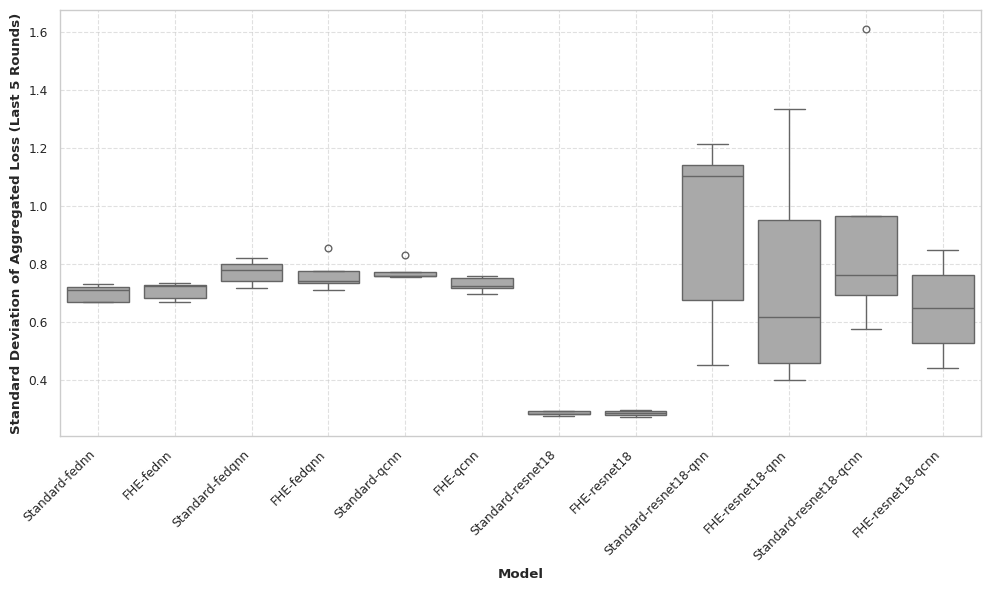

In [54]:
display_boxplot(df, metric_label)